In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

#### Code 7.1

In [3]:
d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
dA1 = dd[dd.cont_africa==1]  # Africa
dA0 = dd[dd.cont_africa==0]  # not Africa

#### Code 7.2

In [4]:
# Fit the regression models with this code.
# African nations
with pm.Model() as model_7_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * dA1['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dA1['rgdppc_2000']))
    trace_7_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1121.68draws/s]


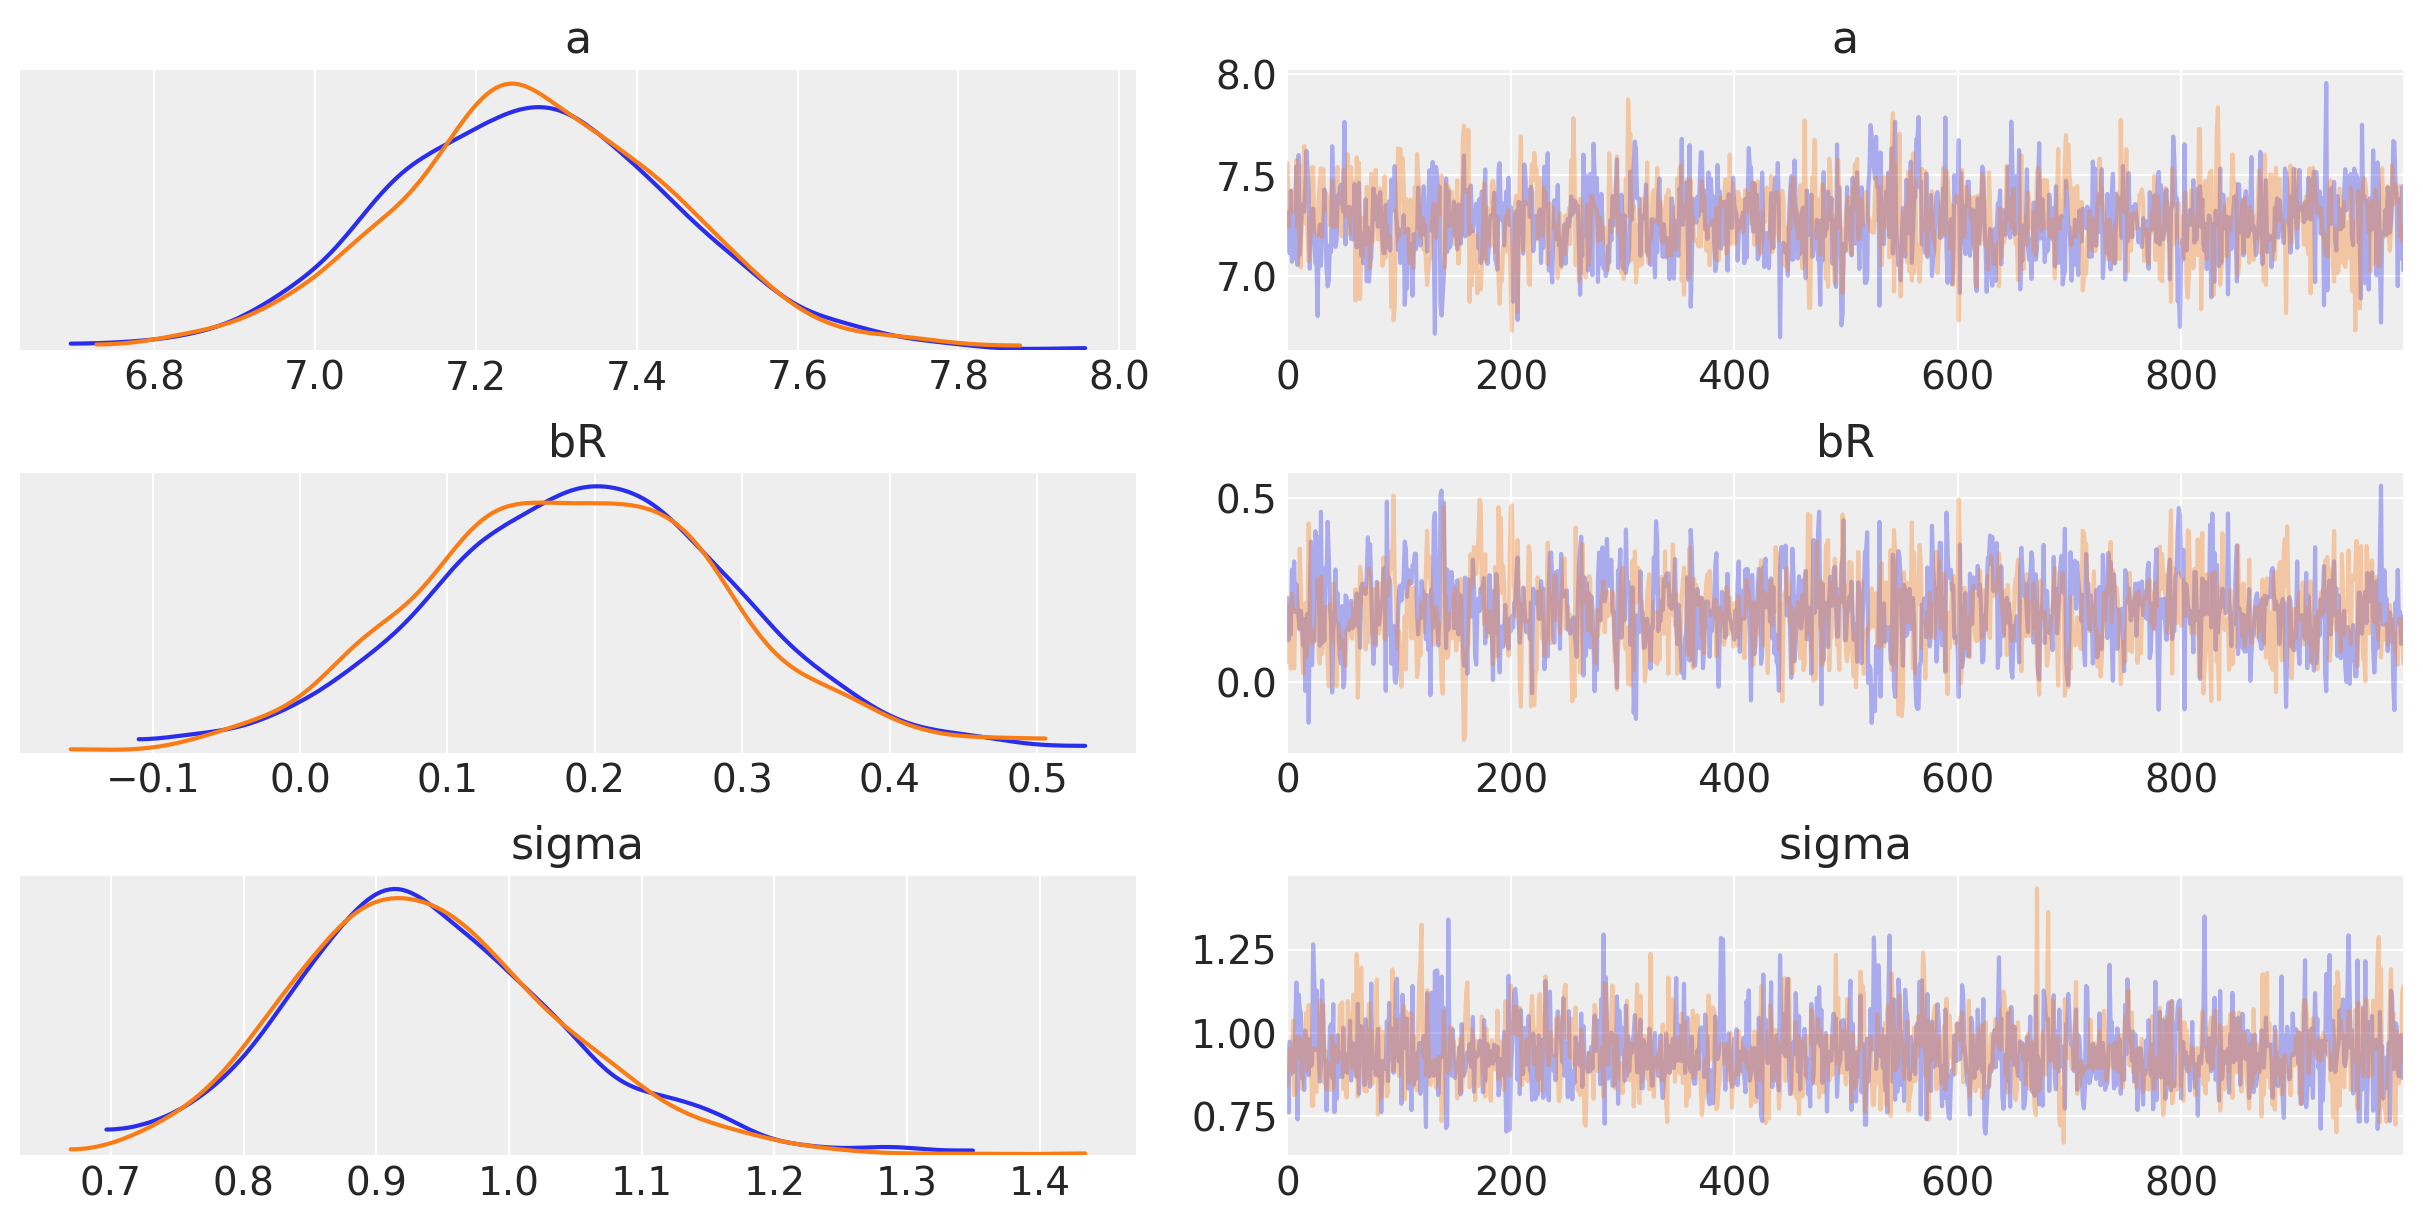

In [5]:
varnames = ['~mu']
pm.traceplot(trace_7_2, varnames);

In [6]:
# non-African nations
with pm.Model() as model_7_2_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * dA0['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dA0['rgdppc_2000']))
    trace_7_2_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1152.16draws/s]


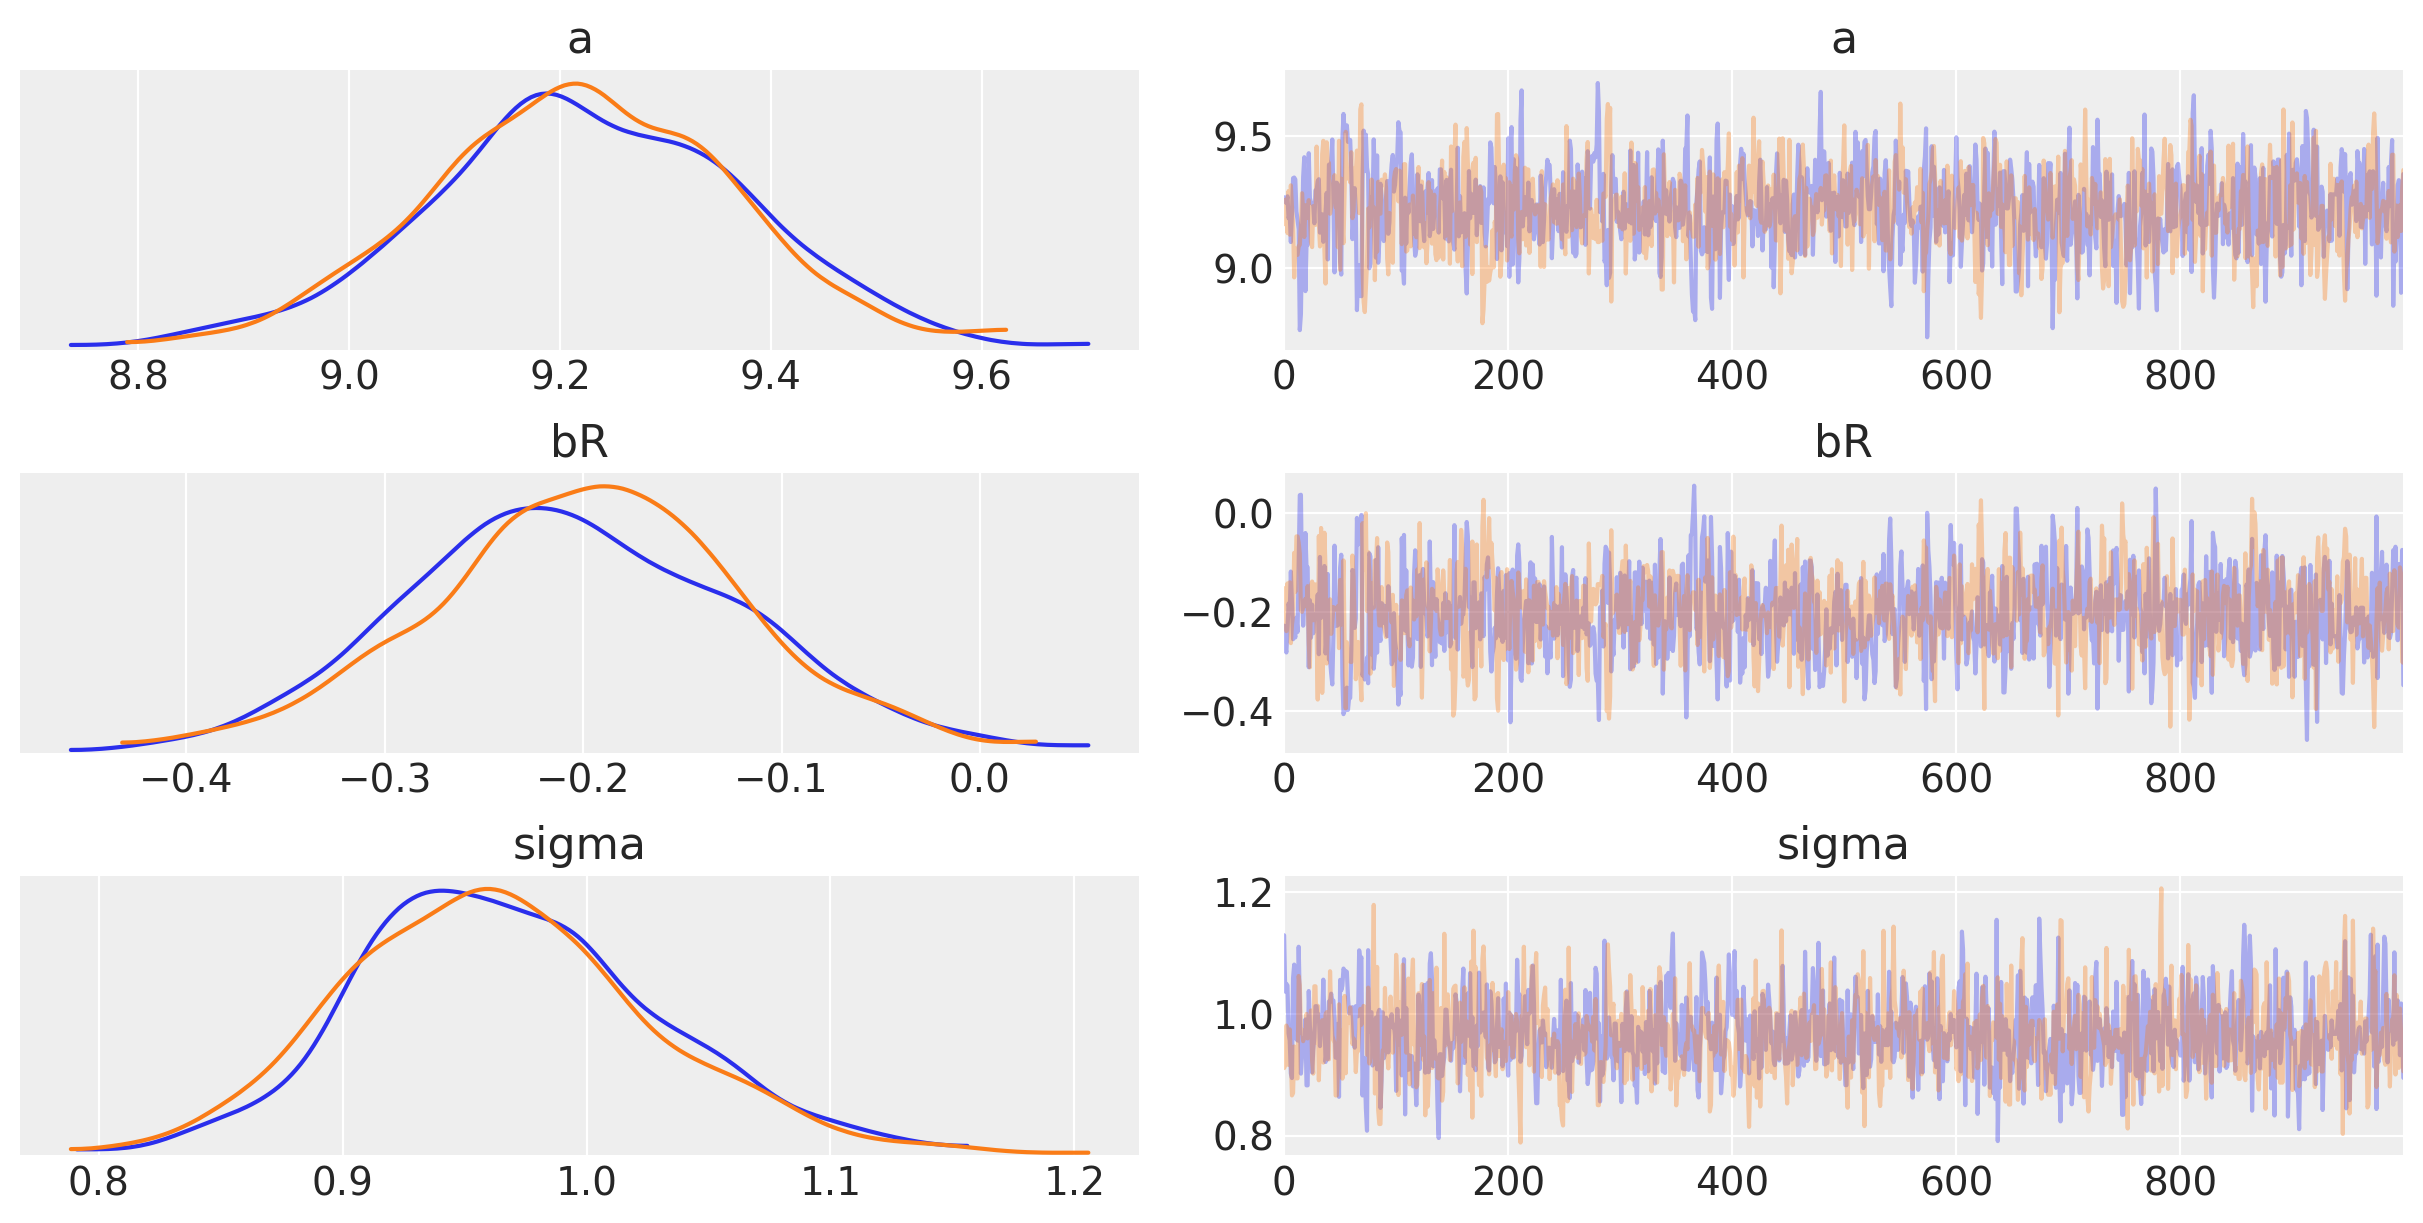

In [7]:
pm.traceplot(trace_7_2_2, varnames);

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


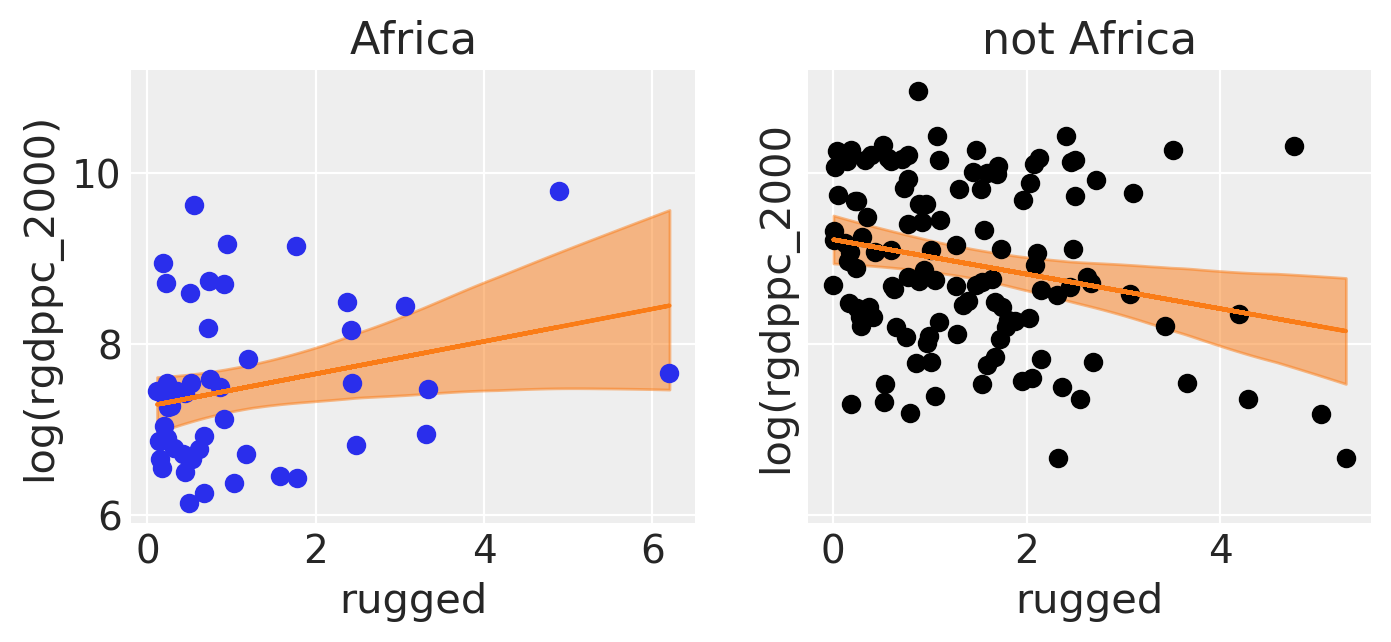

In [8]:
# Plot the data

mu_mean = trace_7_2['mu']
mu_hpd = pm.hpd(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(dA1['rugged'], np.log(dA1['rgdppc_2000']), 'C0o')
ax1.plot(dA1['rugged'], mu_mean.mean(0), 'C1')
az.plot_hpd(dA1['rugged'], mu_mean, ax=ax1)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)');
ax1.set_xlabel('rugged')

mu_mean = trace_7_2_2['mu']

ax2.plot(dA0['rugged'], np.log(dA0['rgdppc_2000']), 'ko')
ax2.plot(dA0['rugged'], mu_mean.mean(0), 'C1')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000')
ax2.set_xlabel('rugged')
az.plot_hpd(dA0['rugged'], mu_mean, ax=ax2);

#### Code 7.3

In [9]:
# Model the entire data
with pm.Model() as model_7_3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 913.76draws/s] 


#### Code 7.4

In [10]:
# Model the entire data including a dummy variable
with pm.Model() as model_7_4:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 703.34draws/s]


#### Code 7.5

WAIC values are point estimates and hence is a good idea to include the uncertainty asociated with their estimation when computing weights. PyMC3 uses a Bayesian bootstrapping to do this (read more [here](https://arxiv.org/abs/1704.02030)), and also to compute the standard error (SE) of WAIC/LOO estimates. If you set `bootstrapping = False` weights (and SE) will be computed as in the book.

In [11]:
comp_df = az.compare({'m7.3' : trace_7_3, 
                      'm7.4' : trace_7_4})
comp_df

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:993: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7.4,476.1,4.17032,0,0.999999,12.74,0,True,deviance
m7.3,539.326,2.50432,63.2269,1.02334e-06,14.4256,14.5321,False,deviance


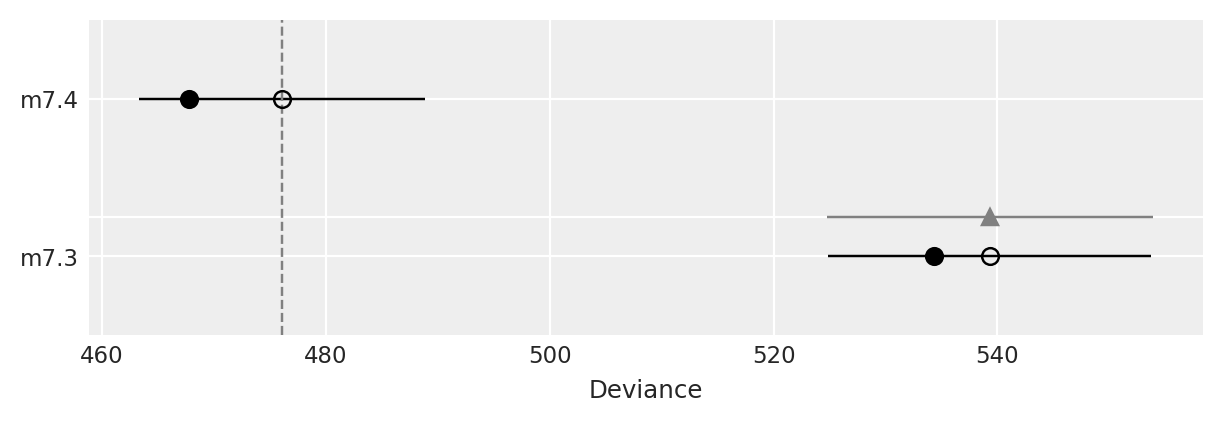

In [12]:
az.plot_compare(comp_df);

#### Code 7.6

Since the link function isn't implemented we have to compute the mean over samples ourselves using a loop.

In [13]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_4['bR'])))

for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 1 

In [14]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_mean_Africa = mu_pred_Africa.mean(1)

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


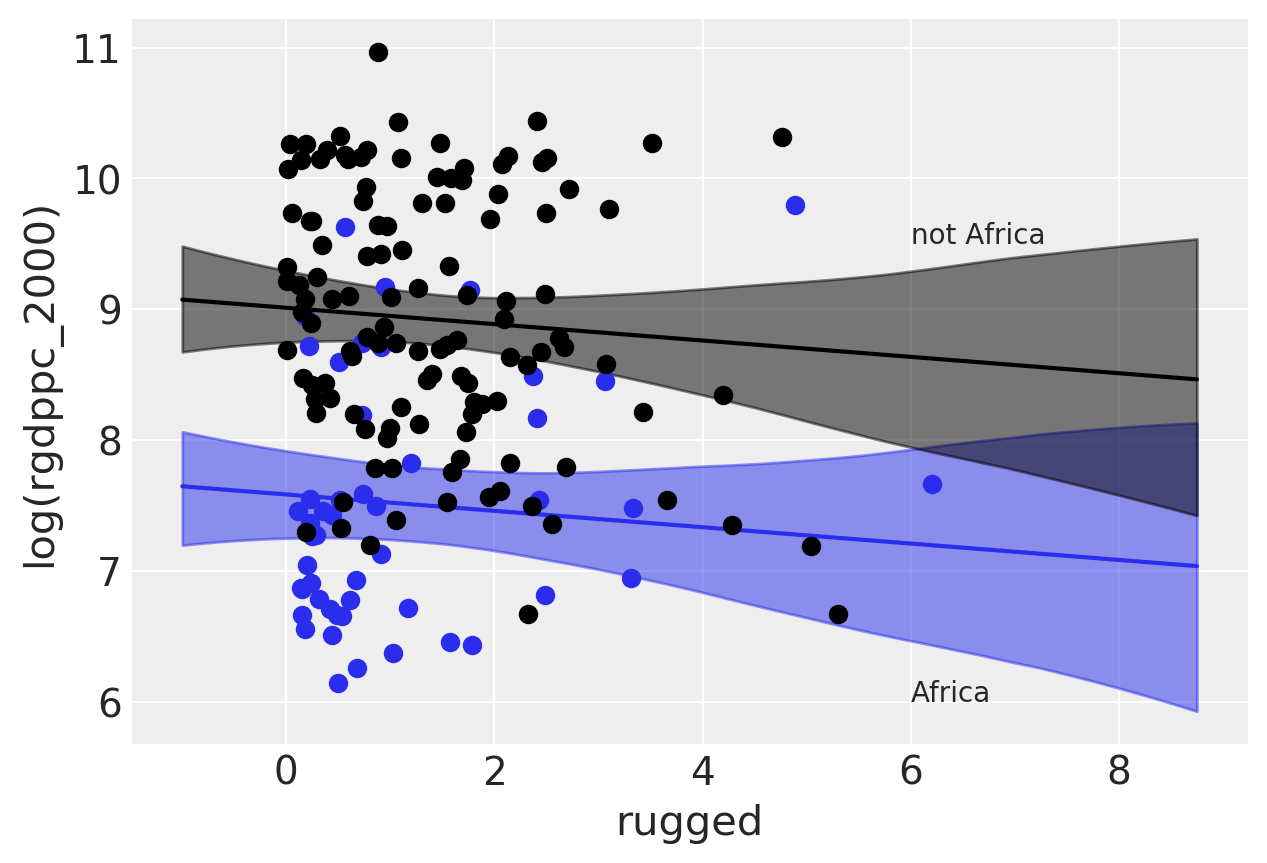

In [15]:
plt.plot(dA1['rugged'], np.log(dA1['rgdppc_2000']), 'C0o')
plt.plot(rugged_seq, mu_mean_Africa, 'C0')
az.plot_hpd(rugged_seq, mu_pred_Africa.T, credible_interval=0.97, color='C0')
plt.plot(dA0['rugged'], np.log(dA0['rgdppc_2000']), 'ko')
plt.plot(rugged_seq, mu_mean_NotAfrica, 'k')
az.plot_hpd(rugged_seq, mu_pred_NotAfrica.T, credible_interval=0.97, color='k')
plt.annotate('not Africa', xy=(6, 9.5))
plt.annotate('Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)')
plt.xlabel('rugged');

#### Code 7.7

In [16]:
with pm.Model() as model_7_5:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 437.09draws/s]


#### Code 7.8

In [17]:
comp_df = az.compare({'m7.3': trace_7_3,
                      'm7.4' : trace_7_4,
                      'm7.5' : trace_7_5})

comp_df

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:993: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:993: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7.5,469.287,4.99138,0,0.837172,12.2031,0,True,deviance
m7.4,476.1,4.17032,6.81234,0.162828,14.781,5.90195,True,deviance
m7.3,539.326,2.50432,70.0393,1.22456e-09,14.7502,14.6363,False,deviance


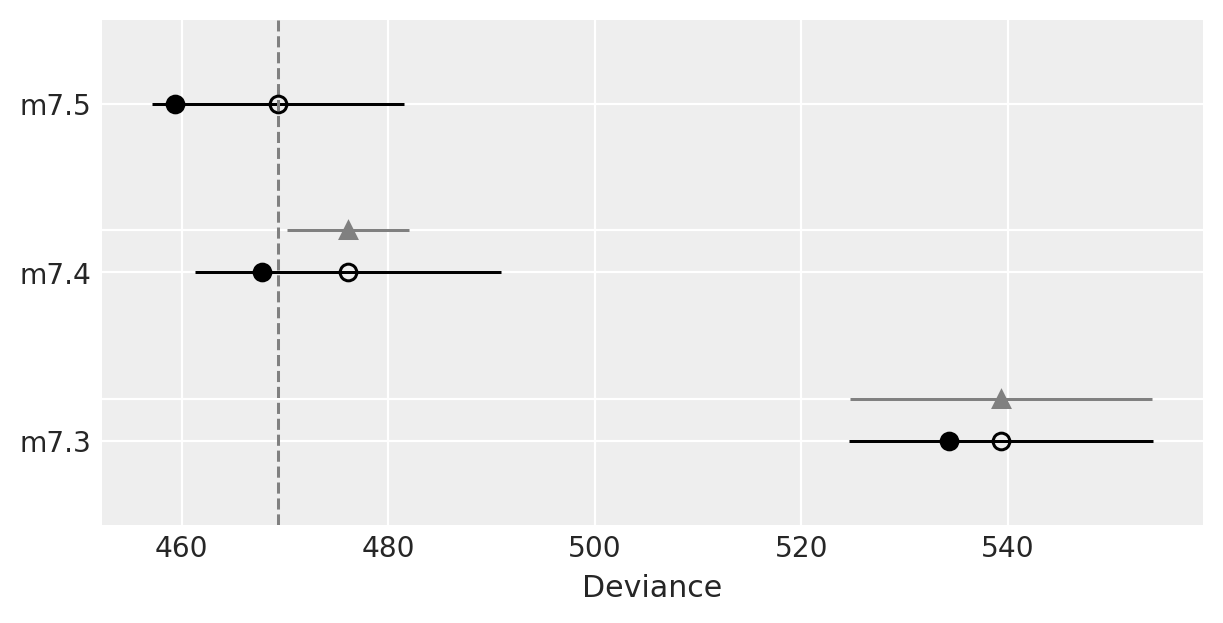

In [18]:
az.plot_compare(comp_df);

#### Code 7.9

In [19]:
with pm.Model() as model_7_5b:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR*dd.rugged + bAR*dd.rugged*dd.cont_africa + bA*dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 428.21draws/s]


#### Code 7.10
First calculate the necessary posterior predicted means. The link function is replaced by a loop. We'll use model 7.5b since it's a one-liner.


In [20]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_5b['bR'])))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*0 +\
                              trace_7_5b['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*1 +\
                              trace_7_5b['bA'] * 1

In [21]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_mean_Africa = mu_pred_Africa.mean(1)

#### Code 7.11

/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


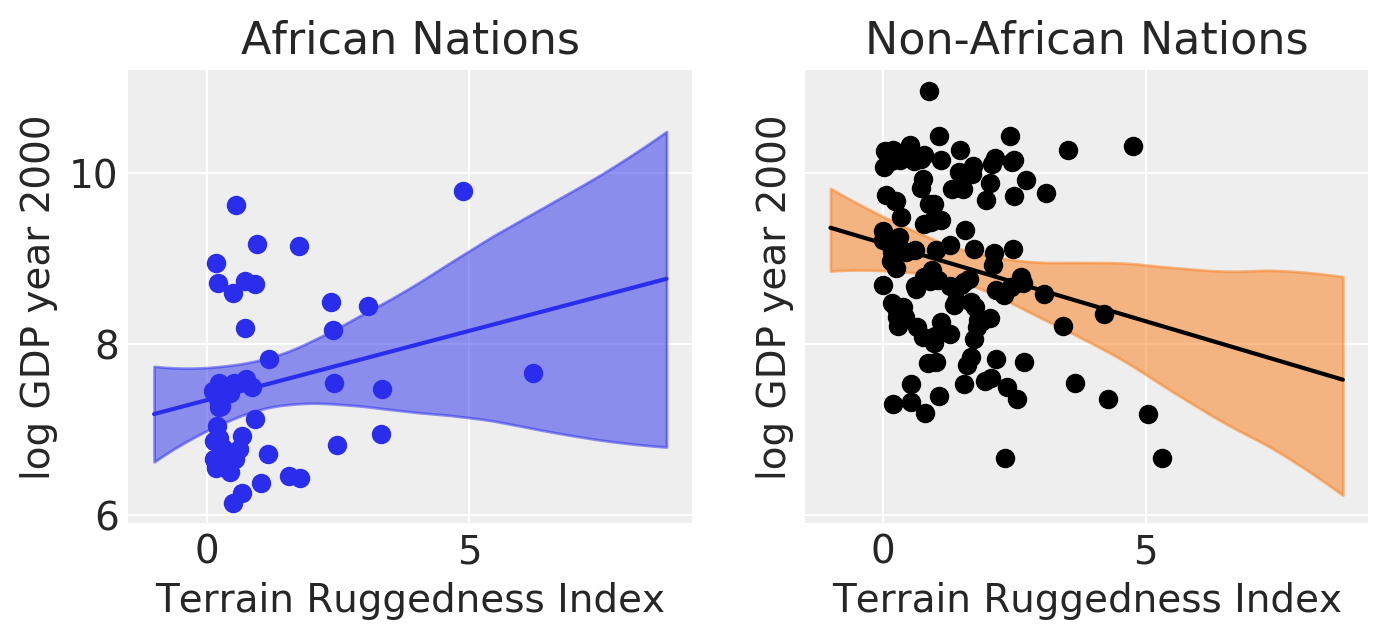

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(dA1['rugged'], np.log(dA1['rgdppc_2000']), 'C0o')
ax1.plot(rugged_seq, mu_mean_Africa, 'C0')
az.plot_hpd(rugged_seq, mu_pred_Africa.T, credible_interval=0.97, color='C0', ax=ax1)

ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(dA0['rugged'], np.log(dA0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
az.plot_hpd(rugged_seq, mu_pred_NotAfrica.T, credible_interval=0.97, color='C1', ax=ax2)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

#### Code 7.12

In [23]:
varnames = ['~mu']
az.summary(trace_7_5b, varnames, credible_interval=.89).round(3)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.179,0.145,0.005,0.003,8.952,9.409,964.0,964.0,972.0,1011.0,1.0
bR,-0.182,0.080,0.003,0.002,-0.306,-0.051,964.0,964.0,968.0,1260.0,1.0
bA,-1.835,0.227,0.008,0.006,-2.183,-1.459,739.0,739.0,730.0,1170.0,1.0
bAR,0.345,0.135,0.005,0.003,0.101,0.526,866.0,866.0,876.0,1152.0,1.0
sigma,0.952,0.054,0.001,0.001,0.866,1.034,1911.0,1877.0,1981.0,1519.0,1.0


#### Code 7.13

In [24]:
gamma_Africa = trace_7_5b['bR'] + trace_7_5b['bAR'] * 1
gamma_notAfrica = trace_7_5b['bR']

#### Code 7.14

In [25]:
print("Gamma within Africa: {:.2f}".format(gamma_Africa.mean()))
print("Gamma outside Africa: {:.2f}".format(gamma_notAfrica.mean()))

Gamma within Africa: 0.16
Gamma outside Africa: -0.18


#### Code 7.15

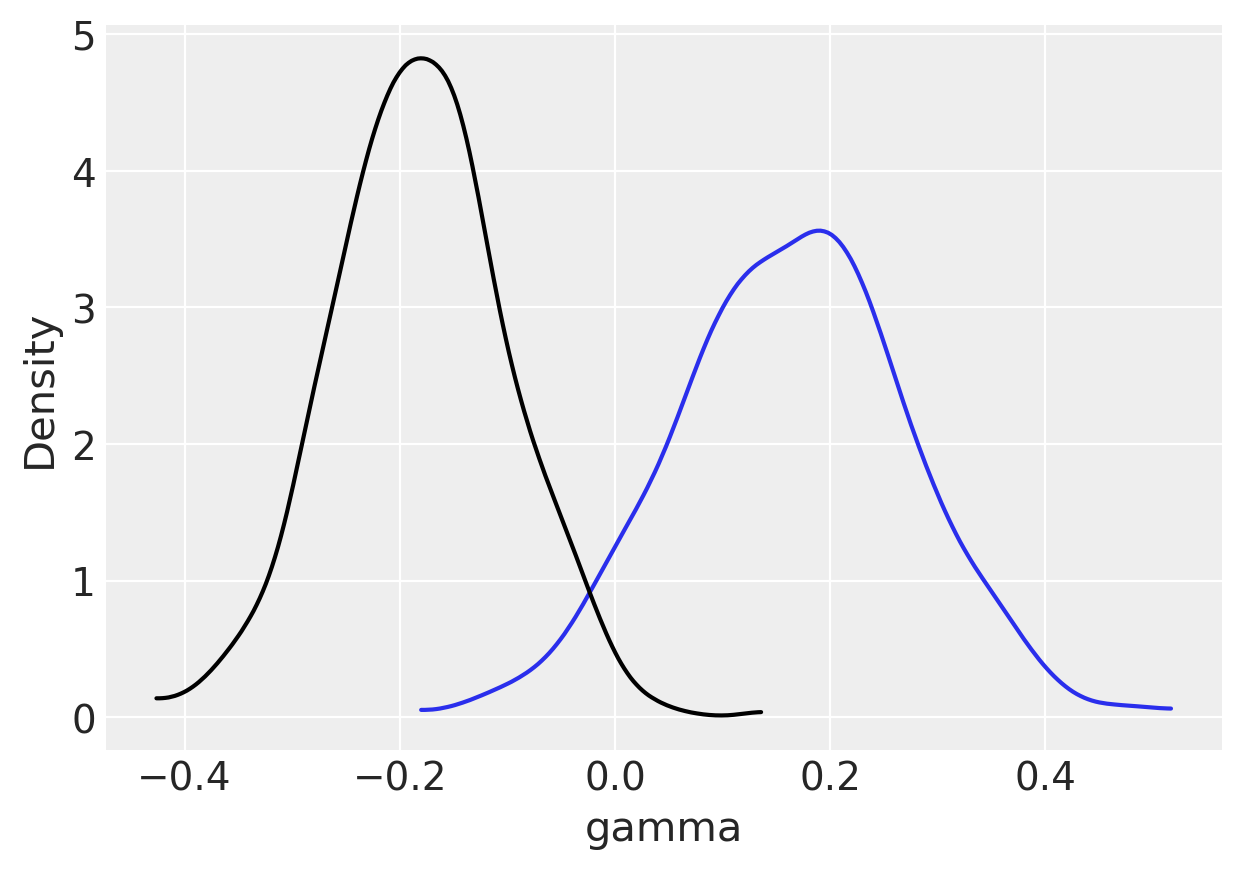

In [26]:
_, ax = plt.subplots()
ax.set_xlabel('gamma')
ax.set_ylabel('Density')
ax.set_ylim(top=5.25)
az.plot_kde(gamma_Africa)
az.plot_kde(gamma_notAfrica, plot_kwargs={'color':'k'});

#### Code 7.16

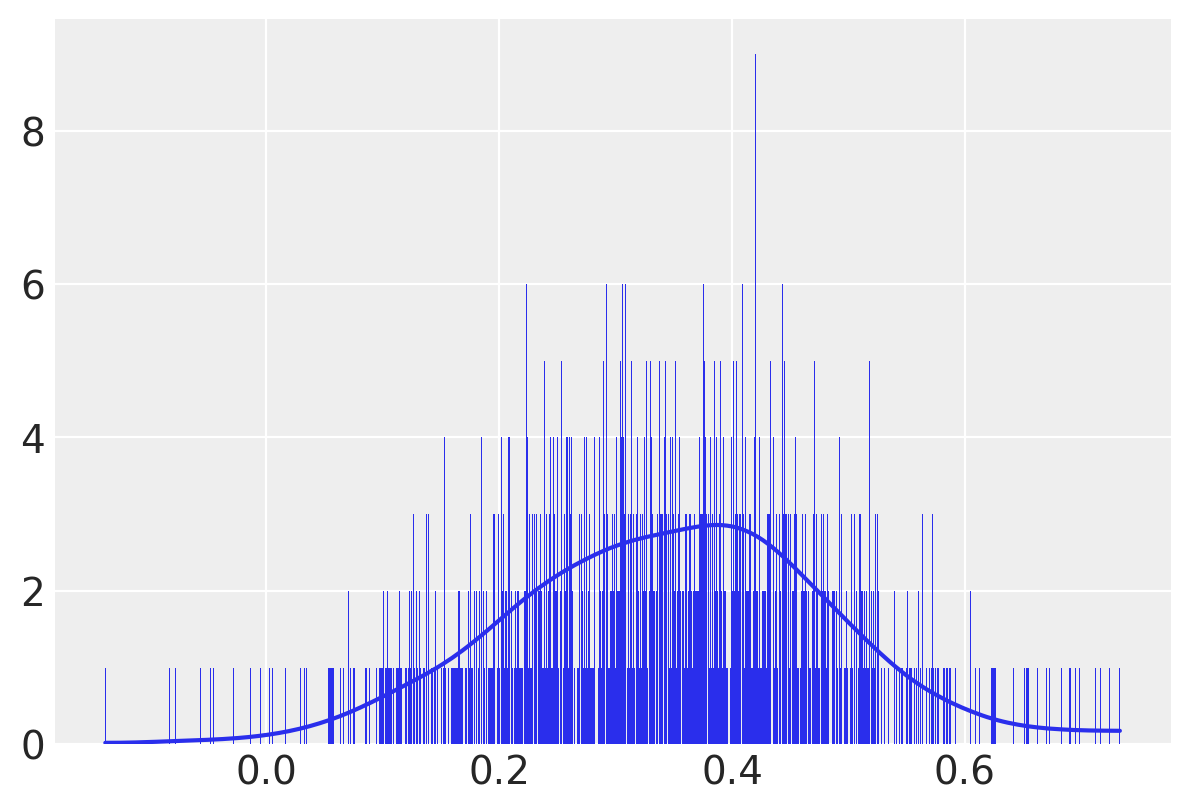

In [27]:
diff = gamma_Africa - gamma_notAfrica
# First let's plot a histogram and a kernel densitiy estimate.
az.plot_kde(diff)
plt.hist(diff, bins=len(diff));
# Notice that there are very few values below zero.

Hence the probability to have a negative slope association ruggedness with log-GDP inside Africa is so small, it might just be zero.

In [28]:
sum(diff[diff < 0]) / len(diff)

-0.0003315733048074939

#### Code 7.17
Plot the reverse interpretation: The influence of being in Africa depends upon terrain ruggedness.

This places `cont_africa` on the horizontal axis, while using different lines for different values of `rugged`.

In [29]:
# Get min and max rugged values.
q_rugged = [0, 0]
q_rugged[0] = np.min(dd.rugged)
q_rugged[1] = np.max(dd.rugged)

In [30]:
# Compute lines and confidence intervals.
# Since the link function isn't implemented we have to again compute the mean over samples ourselves using a loop.
mu_ruggedlo = np.zeros((2, len(trace_7_5b['bR'])))
mu_ruggedhi = np.zeros((2, len(trace_7_5b['bR'])))
# Iterate over outside Africa (0) and inside Africa (1).
for iAfri in range(0,2):
    mu_ruggedlo[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[0] + \
                              trace_7_5b['bAR'] * q_rugged[0] * iAfri + \
                              trace_7_5b['bA'] * iAfri
    mu_ruggedhi[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[1] + \
                              trace_7_5b['bAR'] * q_rugged[1] * iAfri + \
                              trace_7_5b['bA'] * iAfri

In [31]:
mu_ruggedlo_mean = np.mean(mu_ruggedlo, axis=1)
mu_hpd_ruggedlo = pm.hpd(mu_ruggedlo.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_ruggedhi_mean = np.mean(mu_ruggedhi, axis=1)
mu_hpd_ruggedhi = pm.hpd(mu_ruggedhi.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03

In [32]:
# Source http://matplotlib.org/examples/pylab_examples/spine_placement_demo.html
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))  # outward by 5 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

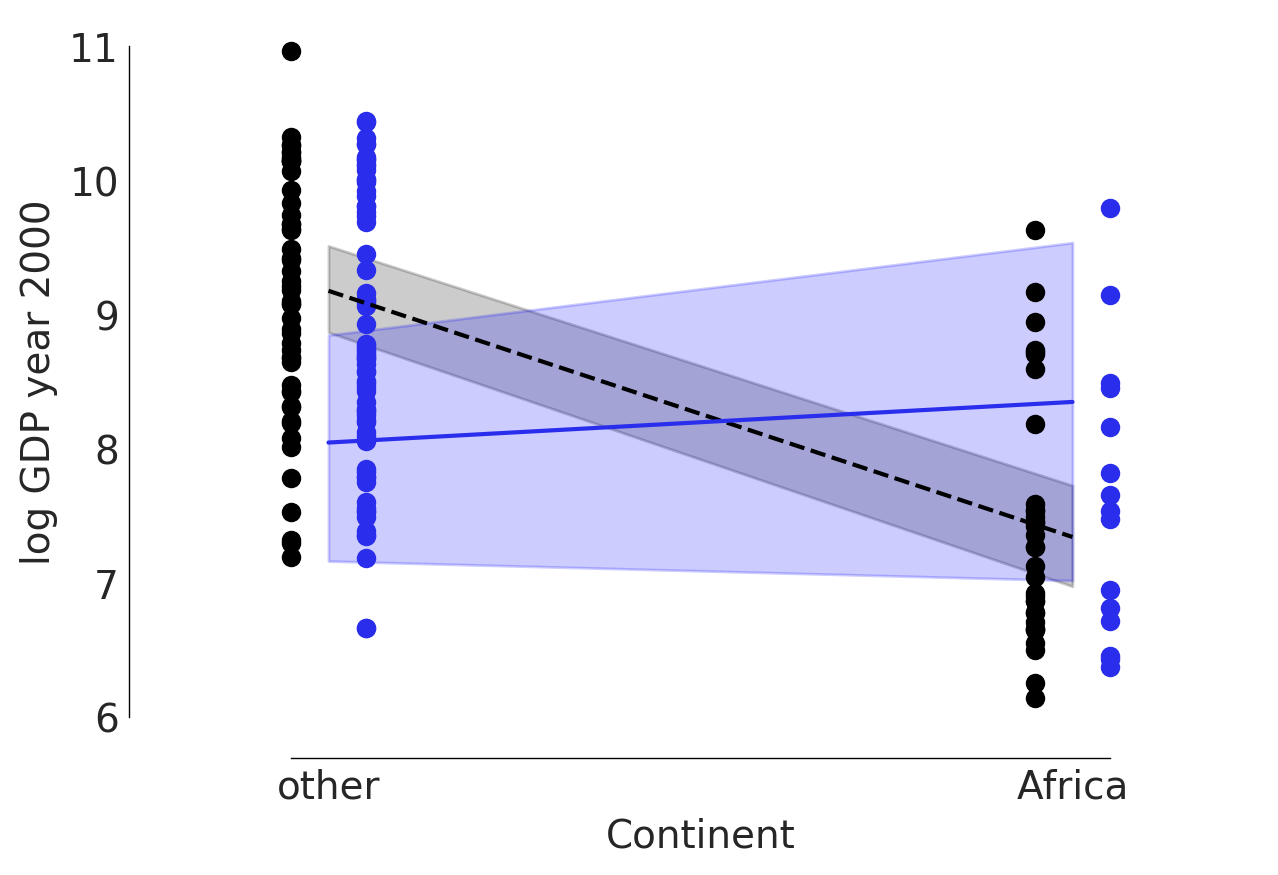

In [33]:
# Plot it all, splitting points at median
med_r = np.median(dd.rugged)
# Use list comprehension to split points at median
ox = [0.05 if x > med_r else -0.05 for x in dd.rugged]
idxk = [i for i,x in enumerate(ox) if x == -0.05]
idxb = [i for i,x in enumerate(ox) if x == 0.05]
cont_africa_ox = dd.cont_africa + ox
plt.plot(cont_africa_ox[dd.cont_africa.index[idxk]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxk]]), 'ko')
plt.plot(cont_africa_ox[dd.cont_africa.index[idxb]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxb]]), 'C0o')
plt.plot([0, 1], mu_ruggedlo_mean, 'k--')
plt.plot([0, 1], mu_ruggedhi_mean, 'C0')
plt.fill_between([0, 1], mu_hpd_ruggedlo[:,0], mu_hpd_ruggedlo[:,1], color='k', alpha=0.2)
plt.fill_between([0, 1], mu_hpd_ruggedhi[:,0], mu_hpd_ruggedhi[:,1], color='b', alpha=0.2)
plt.ylabel('log GDP year 2000', fontsize=14);
plt.xlabel('Continent', fontsize=14)
axes = plt.gca()
axes.set_xlim([-0.25, 1.25])
axes.set_ylim([5.8, 11.2])
axes.set_xticks([0, 1])
axes.set_xticklabels(['other', 'Africa'], fontsize=12)
axes.set_facecolor('white')
adjust_spines(axes, ['left', 'bottom'])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_linewidth(0.5)
axes.spines['left'].set_linewidth(0.5)
axes.spines['bottom'].set_color('black')
axes.spines['left'].set_color('black');

#### Code 7.16

In [34]:
d = pd.read_csv('Data/tulips.csv', sep=';', header=0)
d.info()
d.head()
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
bed       27 non-null object
water     27 non-null int64
shade     27 non-null int64
blooms    27 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 944.0+ bytes


,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


#### Code 7.19

In [35]:
with pm.Model() as model_7_6:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 412.85draws/s]


In [36]:
with pm.Model() as model_7_7:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade + bWS*d.water*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:17<00:00, 233.08draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6560769913771838, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [37]:
map_7_6 = pm.find_MAP(model=model_7_6)
map_7_6

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -175.26, ||grad|| = 0.0011502: 100%|██████████| 24/24 [00:00<00:00, 1082.61it/s]  


{'a': array(44.02992948),
 'bS': array(-34.77920715),
 'bW': array(76.44616379),
 'mu': array([ 85.69688612,  50.91767897,  16.13847183, 162.14304991,
        127.36384277,  92.58463562, 238.58921371, 203.81000656,
        169.03079941,  85.69688612,  50.91767897,  16.13847183,
        162.14304991, 127.36384277,  92.58463562, 238.58921371,
        203.81000656, 169.03079941,  85.69688612,  50.91767897,
         16.13847183, 162.14304991, 127.36384277,  92.58463562,
        238.58921371, 203.81000656, 169.03079941]),
 'sigma': array(100.),
 'sigma_interval__': array(19.99194662)}

In [38]:
map_7_7 = pm.find_MAP(model=model_7_7)
map_7_7

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -170.17, ||grad|| = 0.012971: 100%|██████████| 54/54 [00:00<00:00, 1531.53it/s]    


{'a': array(-84.31089711),
 'bS': array(34.9836048),
 'bW': array(151.00906588),
 'bWS': array(-39.50317218),
 'mu': array([ 62.17860138,  57.659034  ,  53.13946661, 173.68449507,
        129.66175551,  85.63901594, 285.19038877, 201.66447702,
        118.13856527,  62.17860138,  57.659034  ,  53.13946661,
        173.68449507, 129.66175551,  85.63901594, 285.19038877,
        201.66447702, 118.13856527,  62.17860138,  57.659034  ,
         53.13946661, 173.68449507, 129.66175551,  85.63901594,
        285.19038877, 201.66447702, 118.13856527]),
 'sigma': array(46.253541),
 'sigma_interval__': array(-0.15013976)}

#### Code 7.20
You can use the modified Powell's method if it fails with BFGS (default MAP estimate)

In [39]:
from scipy import optimize
map_7_6 = pm.find_MAP(model=model_7_6, method='Powell')
map_7_6

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:502: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -170.22, ||grad|| = 0.11488: 100%|██████████| 224/224 [00:00<00:00, 1500.93it/s]        


{'a': array(88.0937284),
 'bS': array(-38.86994299),
 'bW': array(58.99402102),
 'mu': array([108.21780642,  69.34786343,  30.47792044, 167.21182744,
        128.34188445,  89.47194146, 226.20584846, 187.33590547,
        148.46596248, 108.21780642,  69.34786343,  30.47792044,
        167.21182744, 128.34188445,  89.47194146, 226.20584846,
        187.33590547, 148.46596248, 108.21780642,  69.34786343,
         30.47792044, 167.21182744, 128.34188445,  89.47194146,
        226.20584846, 187.33590547, 148.46596248]),
 'sigma': array(58.82119774),
 'sigma_interval__': array(0.35657868)}

In [40]:
map_7_7 = pm.find_MAP(model=model_7_7, method='Powell')
map_7_7

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/osvaldo/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:502: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -176.57, ||grad|| = 1.3111: 100%|██████████| 640/640 [00:00<00:00, 1044.61it/s]        


{'a': array(98.23420593),
 'bS': array(-41.50750244),
 'bW': array(53.39247436),
 'bWS': array(1.57395991),
 'mu': array([111.69313777,  71.75959524,  31.82605271, 166.65957204,
        128.29998941,  89.94040679, 221.62600631, 184.84038359,
        148.05476088, 111.69313777,  71.75959524,  31.82605271,
        166.65957204, 128.29998941,  89.94040679, 221.62600631,
        184.84038359, 148.05476088, 111.69313777,  71.75959524,
         31.82605271, 166.65957204, 128.29998941,  89.94040679,
        221.62600631, 184.84038359, 148.05476088]),
 'sigma': array(60.0267945),
 'sigma_interval__': array(0.40658167)}

#### Code 7.21
`conftab` is not implemented in PyMC3, something similar is to use `summary()`

In [41]:
az.summary(trace_7_6, var_names=['~mu'])['mean']

a        54.292
bW       75.979
bS      -38.706
sigma    63.851
Name: mean, dtype: float64

In [42]:
az.summary(trace_7_7, var_names=['~mu'])['mean']

a        -71.636
bW       145.225
bS        29.433
bWS      -36.971
sigma     52.924
Name: mean, dtype: float64

#### Code 7.22

In [43]:
comp_df = az.compare({'m7.6' : trace_7_6,
                      'm7.7' : trace_7_7})

comp_df

/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:993: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/home/osvaldo/proyectos/00_PyMC3/arviz/arviz/stats/stats.py:993: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7.7,294.164,4.21039,0,0.959849,7.10308,0,True,deviance
m7.6,303.571,3.57927,9.40741,0.0401512,7.24762,3.76708,True,deviance


#### 7.23
Center and re-estimate

In [44]:
d['shade_c'] = d.shade - np.mean(d.shade)
d['water_c'] = d.water - np.mean(d.water)

#### 7.24
No interaction.

In [45]:
with pm.Model() as model_7_8:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water_c + bS*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_8 = pm.sample(1000, tune=1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 677.50draws/s]
The acceptance probability does not match the target. It is 0.88728731457258, but should be close to 0.8. Try to increase the number of tuning steps.


Interaction.

In [46]:
with pm.Model() as model_7_9:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water_c + bS*d.shade_c + bWS*d.water_c*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_9 = pm.sample(1000, tune=1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'bWS':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 615.02draws/s]


In [47]:
map_7_8 = pm.find_MAP(model=model_7_8)
map_7_8

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -196.39, ||grad|| = 0.32474: 100%|██████████| 16/16 [00:00<00:00, 1456.64it/s]  


{'a': array(124.38684955),
 'bS': array(-39.413174),
 'bW': array(71.81213462),
 'mu': array([ 91.98788894,  52.57471493,  13.16154093, 163.80002355,
        124.38684955,  84.97367554, 235.61215817, 196.19898417,
        156.78581016,  91.98788894,  52.57471493,  13.16154093,
        163.80002355, 124.38684955,  84.97367554, 235.61215817,
        196.19898417, 156.78581016,  91.98788894,  52.57471493,
         13.16154093, 163.80002355, 124.38684955,  84.97367554,
        235.61215817, 196.19898417, 156.78581016]),
 'sigma': array(100.),
 'sigma_interval__': array(48.62145626)}

In [48]:
map_7_9 = pm.find_MAP(model=model_7_9)
map_7_9

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -201.51, ||grad|| = 0.32861: 100%|██████████| 18/18 [00:00<00:00, 1293.21it/s]  


{'a': array(124.3869317),
 'bS': array(-39.4133895),
 'bW': array(71.81252725),
 'bWS': array(-48.78655415),
 'mu': array([ 43.20123979,  52.57440445,  61.9475691 , 163.80032119,
        124.3869317 ,  84.9735422 , 284.39940259, 196.19945895,
        107.9995153 ,  43.20123979,  52.57440445,  61.9475691 ,
        163.80032119, 124.3869317 ,  84.9735422 , 284.39940259,
        196.19945895, 107.9995153 ,  43.20123979,  52.57440445,
         61.9475691 , 163.80032119, 124.3869317 ,  84.9735422 ,
        284.39940259, 196.19945895, 107.9995153 ]),
 'sigma': array(100.),
 'sigma_interval__': array(50.89448125)}

#### 7.25

In [49]:
map_7_7['a'] + map_7_7['bW'] * 2 + map_7_7['bS'] * 2 + map_7_7['bWS'] * 2 * 2

128.2999894141329

#### 7.26

In [50]:
map_7_9['a'] + map_7_9['bW'] * 0 + map_7_9['bS'] * 0 + map_7_9['bWS'] * 0 * 0

124.38693169605965

#### 7.27

In [51]:
varnames = ['a', 'bW', 'bS', 'bWS', 'sigma']
az.summary(trace_7_9, varnames, credible_interval=.89).round(3)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,127.609,10.172,0.204,0.144,112.149,144.257,2479.0,2479.0,2498.0,1640.0,1.0
bW,74.717,12.471,0.262,0.186,56.290,95.997,2273.0,2249.0,2246.0,1416.0,1.0
bS,-40.509,12.250,0.263,0.198,-58.230,-19.225,2177.0,1913.0,2154.0,1219.0,1.0
bWS,-51.603,15.221,0.317,0.231,-76.630,-28.285,2300.0,2179.0,2269.0,1454.0,1.0
sigma,52.389,8.244,0.211,0.155,40.013,65.896,1521.0,1418.0,1686.0,1249.0,1.0


#### 7.28

We have to replace the `link` function with a loop.

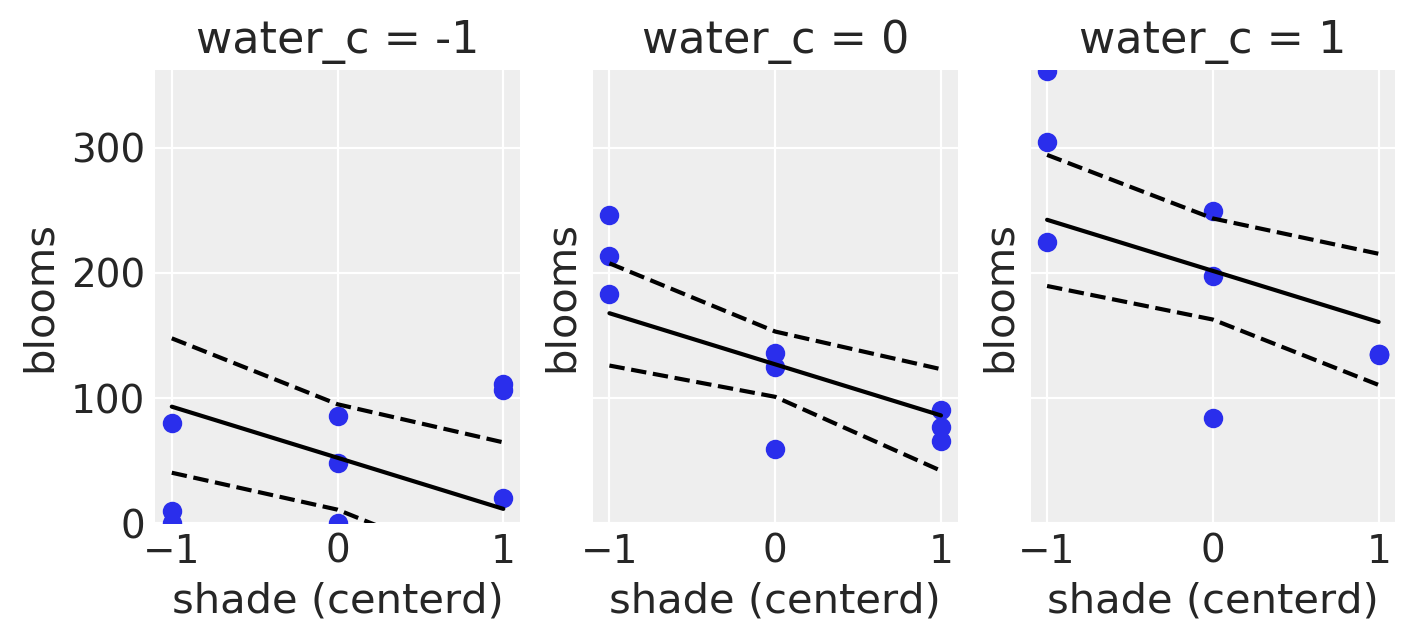

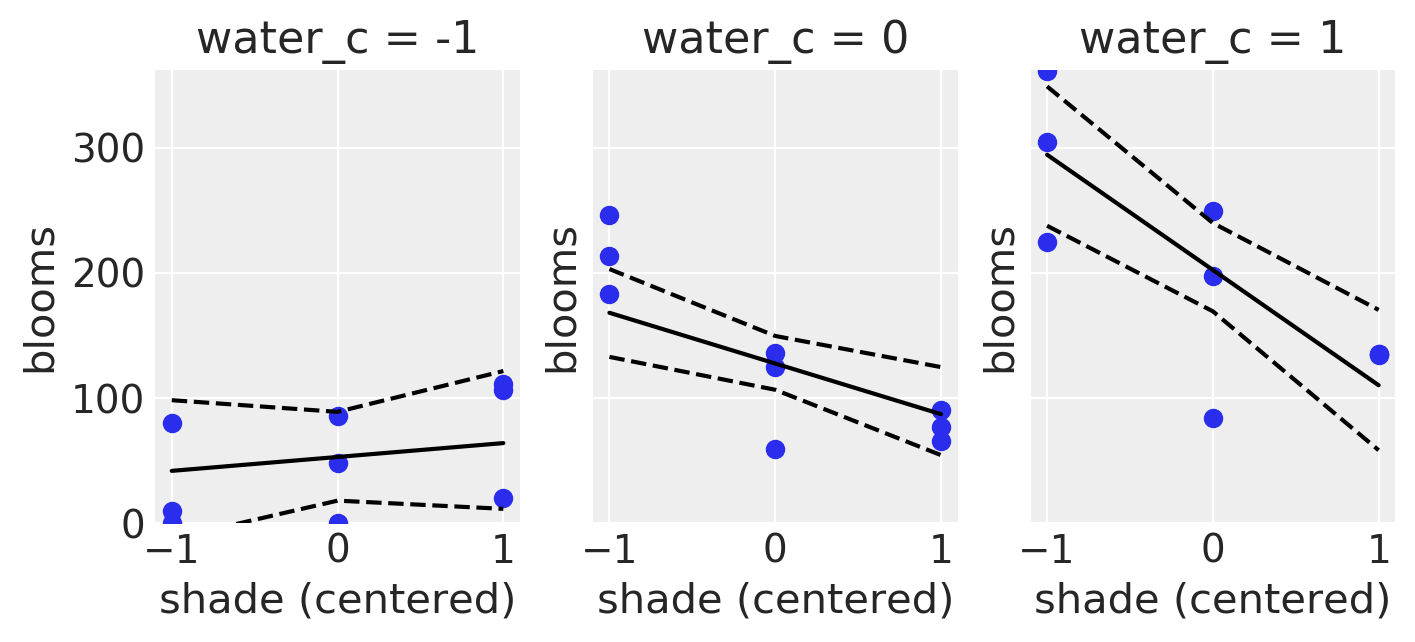

In [52]:
# No interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
shade_seq = range(-1, 2, 1)

mu_w = np.zeros((len(shade_seq), len(trace_7_8['a'])))
for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'C0o')
    for x, iSeq in enumerate(shade_seq):
        mu_w[x] = trace_7_8['a'] + trace_7_8['bW'] * w + trace_7_8['bS'] * iSeq
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = pm.hpd(mu_w.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], 'k--')
    ax.plot(shade_seq, mu_hpd_w.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centerd)')
    ax.set_title('water_c = {:d}'.format(w))
    ax.set_xticks(shade_seq)
    ax.set_yticks(range(0, 301, 100))

# Interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
shade_seq = range(-1, 2, 1)

mu_w = np.zeros((len(shade_seq), len(trace_7_9['a'])))
for ax, w in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.water_c == w]
    ax.plot(dt.shade-np.mean(dt.shade), dt.blooms, 'C0o')
    for x, iSeq in enumerate(shade_seq):
        mu_w[x] = trace_7_9['a'] + trace_7_9['bW'] * w + trace_7_9['bS'] * iSeq + trace_7_9['bWS'] * w * iSeq
    mu_mean_w = mu_w.mean(1)
    mu_hpd_w = az.hpd(mu_w.T, credible_interval=0.97)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(shade_seq, mu_mean_w, 'k')
    ax.plot(shade_seq, mu_hpd_w.T[0], 'k--')
    ax.plot(shade_seq, mu_hpd_w.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('shade (centered)')
    ax.set_title('water_c = {:d}'.format(w))
    ax.set_xticks(shade_seq)
    ax.set_yticks(range(0, 301, 100))

Let's remake the plots with water on abscissa while varying shade levels from left to right.

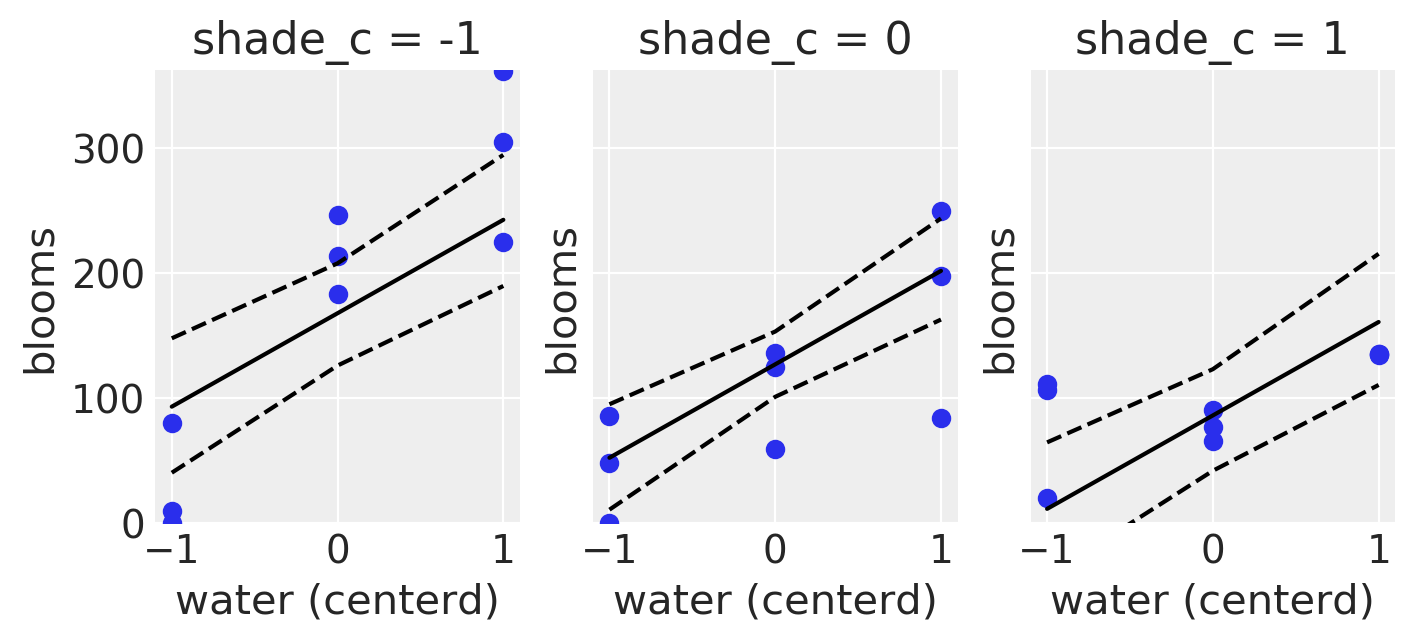

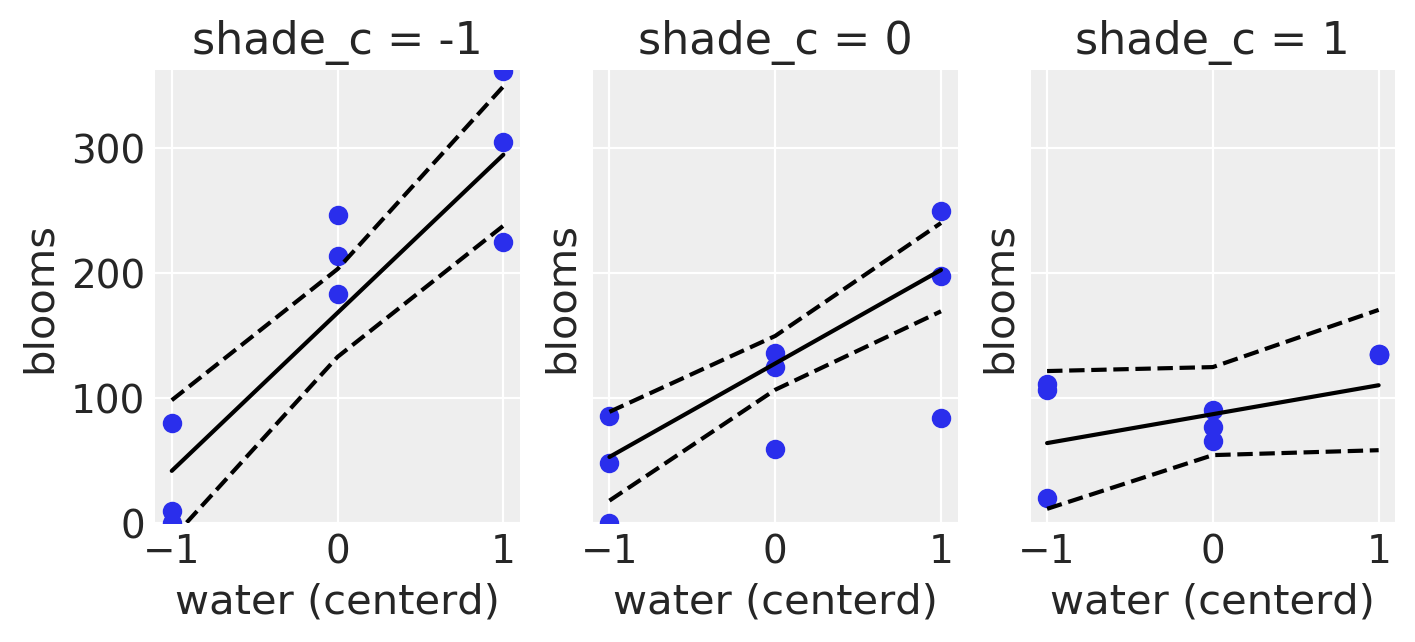

In [53]:
# No interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
water_seq = range(-1, 2, 1)

mu_s = np.zeros((len(water_seq), len(trace_7_8['a'])))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.shade_c == s]
    ax.plot(dt.water-np.mean(dt.water), dt.blooms, 'C0o')
    for x, iSeq in enumerate(shade_seq):
        mu_s[x] = trace_7_8['a'] + trace_7_8['bW'] * iSeq + trace_7_8['bS'] * s
    mu_mean_s = mu_s.mean(1)
    mu_hpd_s = pm.hpd(mu_s.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(water_seq, mu_mean_s, 'k')
    ax.plot(water_seq, mu_hpd_s.T[0], 'k--')
    ax.plot(water_seq, mu_hpd_s.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('water (centerd)')
    ax.set_title('shade_c = {:d}'.format(s))
    ax.set_xticks(water_seq)
    ax.set_yticks(range(0, 301, 100))

# Interaction
f, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))
# Loop over values of water_c and plot predictions.
water_seq = range(-1, 2, 1)

mu_s = np.zeros((len(water_seq), len(trace_7_9['a'])))
for ax, s in zip(axs.flat, range(-1, 2, 1)):
    dt = d[d.shade_c == s]
    ax.plot(dt.water-np.mean(dt.water), dt.blooms, 'C0o')
    for x, iSeq in enumerate(water_seq):
        mu_s[x] = trace_7_9['a'] + trace_7_9['bW'] * iSeq + trace_7_9['bS'] * s + trace_7_9['bWS'] * iSeq * s
    mu_mean_s = mu_s.mean(1)
    mu_hpd_s = az.hpd(mu_s.T, credible_interval=.97)  # 97% probability interval: 1-.97 = 0.03
    ax.plot(water_seq, mu_mean_s, 'k')
    ax.plot(water_seq, mu_hpd_s.T[0], 'k--')
    ax.plot(water_seq, mu_hpd_s.T[1], 'k--')
    ax.set_ylim(0,362)
    ax.set_ylabel('blooms')
    ax.set_xlabel('water (centerd)')
    ax.set_title('shade_c = {:d}'.format(s))
    ax.set_xticks(water_seq)
    ax.set_yticks(range(0, 301, 100))

When there is no interaction the slope is the same across all three plots (top row), showing a general reduction with increasing shade. For the interaction (bottom row) we can see a huge increase in blooms for the lowest amount of shade as we increase water. This effect is reduced by increasing shade to average levels and in the last plot increasing water has a minimum effect when there is lots of shade.

#### 7.29

In [54]:
m_7_x = smf.ols('blooms ~ shade + water + shade * water', data=d).fit()

#### 7.30

In [55]:
m_7_x = smf.ols('blooms ~ shade * water', data=d).fit()

#### 7.31

In [56]:
m_7_x = smf.ols('blooms ~ shade * water - water', data=d).fit()

#### 7.32

In [57]:
m_7_x = smf.ols('blooms ~ shade * water * bed', data=d).fit()

#### 7.33
Not sure how this one works

In [58]:
from patsy import dmatrix
x, y, z = 1, 1, 1
d_matrix = dmatrix('~ x * y * w')
d_matrix.design_info.column_names 

['Intercept', 'x', 'y', 'x:y', 'w', 'x:w', 'y:w', 'x:y:w']

In [59]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.1
IPython 6.2.1
PyMC3 3.7.rc1
ArviZ 0.4.0
NumPy 1.15.4
SciPy 1.1.0
Matplotlib 3.0.2

